In [280]:
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
%matplotlib inline

In [281]:
train = pd.read_csv("data/train.csv",sep=',')
test = pd.read_csv("data/test.csv",sep=',')

 ## Visualizacao basica dos dados

In [286]:
train.head(5)

,Id,tipo,bairro,tipo_vendedor,quartos,suites,vagas,area_util,area_extra,diferenciais,...,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,sauna,vista_mar,preco
0,2000,Casa,Imbiribeira,Imobiliaria,3,3,5,223,167,piscina e copa,...,0,1,0,0,0,0,0,0,0,1000000.0
1,2001,Apartamento,Casa Amarela,Imobiliaria,4,4,2,157,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,680000.0
2,2002,Apartamento,Encruzilhada,Imobiliaria,3,1,0,53,0,nenhum,...,0,0,0,0,0,0,0,0,0,450000.0
3,2003,Apartamento,Boa Viagem,Imobiliaria,4,3,2,149,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,1080000.0
4,2004,Apartamento,Rosarinho,Imobiliaria,2,1,1,54,0,piscina e churrasqueira,...,0,1,0,0,0,0,0,0,0,350000.0


### Verificacao de outliers

4683 linhas no dataser


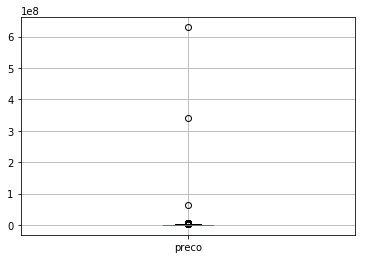

In [283]:
train.boxplot(column = ['preco'])
print("{} linhas no dataser".format(len(train.preco)))

4680 linhas no dataset


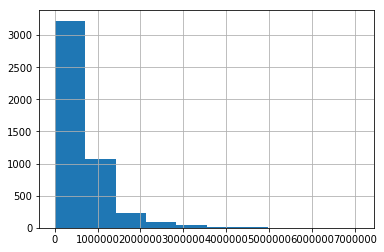

In [302]:
train_without_outliers = train[np.abs(train.preco - train.preco.mean()) <= (2 * train.preco.std())]
train_without_outliers.preco.hist()
print("{} linhas no dataset".format(len(train_without_outliers.preco)))

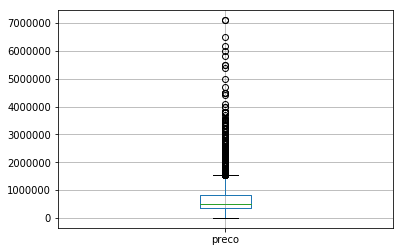

In [303]:
train_without_outliers.boxplot(column = ['preco'])

### One hot encoding

In [304]:
non_discrete_categorical_columns = ['area_util','area_extra']
discrete_categorical_columns = ['quartos','suites','vagas']
binary_columns = ['estacionamento','piscina','playground','quadra','s_festas','s_jogos','s_ginastica','s_ginastica','sauna','vista_mar']


one_hot_data = train_without_outliers.copy()

hot_columns = pd.get_dummies(one_hot_data['tipo'], prefix= 'tipo')
one_hot_data = pd.concat([one_hot_data, hot_columns], axis=1)
one_hot_data = one_hot_data.drop(columns=['tipo'])

for column in discrete_categorical_columns:   
    hot_columns = pd.get_dummies(one_hot_data[column], prefix= column)
    one_hot_data = pd.concat([one_hot_data, hot_columns], axis=1)
    one_hot_data = one_hot_data.drop(columns=[column])

df = one_hot_data.drop(columns=['Id','diferenciais','tipo_vendedor'])
df.head(3)

,bairro,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,...,vagas_7,vagas_8,vagas_10,vagas_12,vagas_13,vagas_15,vagas_17,vagas_18,vagas_20,vagas_30
0,Imbiribeira,223,167,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Casa Amarela,157,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Encruzilhada,53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
## Antes de retirar oluna totoal, dividir as demais por ela, de modoa ter uma proporcao
renda_bairros = pd.read_csv("data/renda_bairros.csv",sep=',')
renda_bairros = renda_bairros.drop(columns=['Total ¹'])
renda_bairros.head(3)

,bairro,Até 1/2 salário mínimo,Mais de 1/2 a 1 salário mínimo,Mais de 1 a 2 salários mínimos,Mais de 2 a 5 salários mínimos,Mais de 5 a 10 salários mínimos,Mais de 10 a 20 salários mínimos,Mais de 20 salários mínimos,Sem rendimento
0,Aflitos,5,24,52,183,433,598,530,112
1,Afogados,402,2151,2812,3342,1272,374,77,642
2,Agua Fria,681,2699,3651,3516,865,167,32,683


In [275]:
woth_column_names = ['meio_salario','meio_1_salario','1_2_salarios','2_5_salarios','5_10_salarios','10_20_salarios','20_salarios','sem_salario']
df_renda = pd.concat([df,df.reindex(columns = woth_column_names)], axis = 1)
df_renda = df_renda[df_renda.bairro != 'Beira Rio']
df_renda = df_renda[df_renda.bairro != 'Centro']
for bairro in list(df_renda.bairro.unique()):
    df_renda.loc[df.bairro == bairro, woth_column_names] = renda_bairros[renda_bairros['bairro'] == bairro].iloc[:,1:].values

df_renda = df_renda.drop(columns=['bairro'])
df_renda.head(5)

,area_util,area_extra,churrasqueira,estacionamento,piscina,playground,quadra,s_festas,s_jogos,s_ginastica,...,vagas_20,vagas_30,meio_salario,meio_1_salario,1_2_salarios,2_5_salarios,5_10_salarios,10_20_salarios,20_salarios,sem_salario
0,223,167,0,0,1,0,0,0,0,0,...,0,0,621,2481.0,3356.0,4220.0,2317,1096,266,612
1,157,0,1,0,1,0,0,0,0,0,...,0,0,113,948.0,1311.0,2505.0,1748,1425,946,300
2,53,0,0,0,0,0,0,0,0,0,...,0,0,16,146.0,267.0,834.0,1143,960,591,51
3,149,0,1,0,1,0,0,0,0,0,...,0,0,362,2191.0,3118.0,6571.0,9175,10302,8914,1639
4,54,0,1,0,1,0,0,0,0,0,...,0,0,26,110.0,131.0,185.0,226,339,269,43
